# Type cleanup and Missing-value treatment study

This notebook focuses on: (1) inspecting and cleaning column types, and (2) a systematic study of missing-value patterns and imputation strategies.

It is intentionally self-contained: open and run cells in order. Adjust file paths if needed.

## Setup: imports and dataset path

In [9]:
import sys
import os

module_path = os.path.abspath("../src")
sys.path.append(module_path)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from preprocessing.data_cleaning import MissingValueHandler, initial_cleanup

sns.set(style="whitegrid")
DATA_PATH = Path('..') / 'data' / 'cleaned_welddb.csv'
columns = [
    "C", "Si", "Mn", "S", "P", "Ni", "Cr", "Mo", "V", "Cu", "Co", "W",
    "O", "Ti", "N", "Al", "B", "Nb", "Sn", "As", "Sb",
    "Current", "Voltage", "AC_DC", "ElectrodePolarity", "HeatInput",
    "InterpassTemp", "WeldType", "PWHT_Temp", "PWHT_Time",
    "YieldStrength", "UTS", "Elongation", "ReductionArea",
    "CharpyTemp", "CharpyImpact", "Hardness", "FATT50", "PrimaryFerrite",
    "Ferrite2ndPhase", "AcicularFerrite", "Martensite", "FerriteCarbide",
    "WeldID"
]
df = pd.read_csv(DATA_PATH)  # load dataset

# Quick peek
df.head()

,C,Si,Mn,S,P,Ni,Cr,Mo,V,Cu,...,CharpyTemp,CharpyImpact,Hardness,FATT50,PrimaryFerrite,Ferrite2ndPhase,AcicularFerrite,Martensite,FerriteCarbide,WeldID
0,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aaw
1,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,...,-28.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aawch
2,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,...,-38.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aht
3,0.037,0.31,1.03,0.007,0.014,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Baw
4,0.037,0.31,1.03,0.007,0.014,0.0,NaN,NaN,NaN,NaN,...,-48.0,100.0,NaN,NaN,32,28.0,40.0,0.0,0.0,Evans-Ni/CMn-1990/1991-0Bawch


## 1. Clean up data types

We inspect dtypes and perform safe conversions: parse dates, coerce numeric strings with `pd.to_numeric(errors='coerce')`, convert low-cardinality object columns to `category`, and normalize boolean-like columns. Always check the number of NaNs introduced by coercion.

In [11]:
df = initial_cleanup(df)
mvh = MissingValueHandler(df)

## 2. Missing values: summary statistics and diagnostics

Compute missing counts and percentages per column and per row, flag columns above thresholds, and produce a compact flagging table with suggested actions.

                 total_missing  pct_missing     dtype  n_unique
FATT50                    1621    98.123487   float32        20
W                         1577    95.460048  category         7
Ferrite2ndPhase           1564    94.673123   float32        44
FerriteCarbide            1563    94.612591   float32         8
Martensite                1563    94.612591   float32         2
AcicularFerrite           1562    94.552058   float32        50
PrimaryFerrite            1556    94.188862   float32        37
Co                        1523    92.191283  category        14
Hardness                  1514    91.646489    object        96
As                        1418    85.835351  category        19
Sb                        1392    84.261501  category        24
Sn                        1356    82.082324  category        20
B                         1148    69.491525  category        30
Cu                        1074    65.012107    object        77
Ni                        1030    62.348

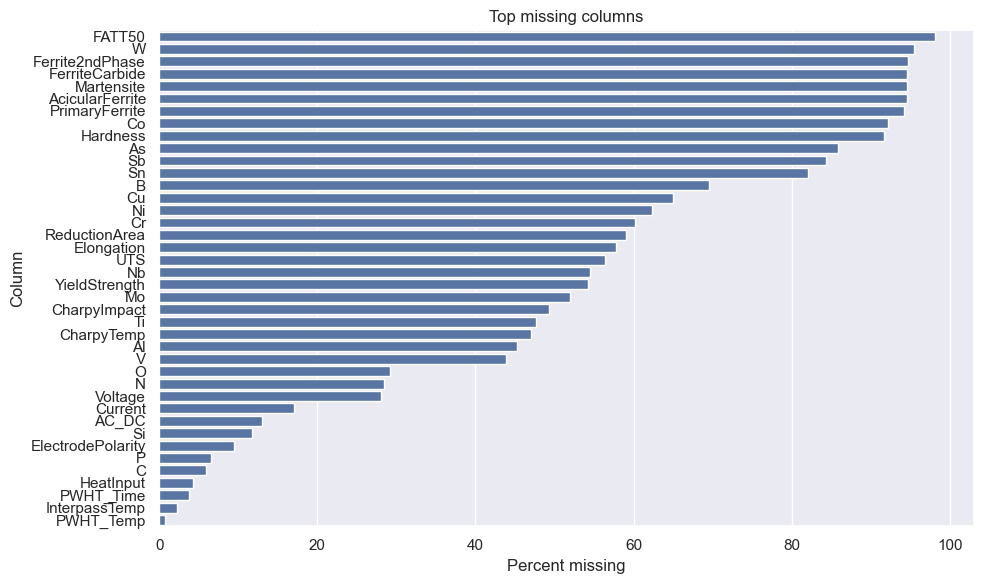

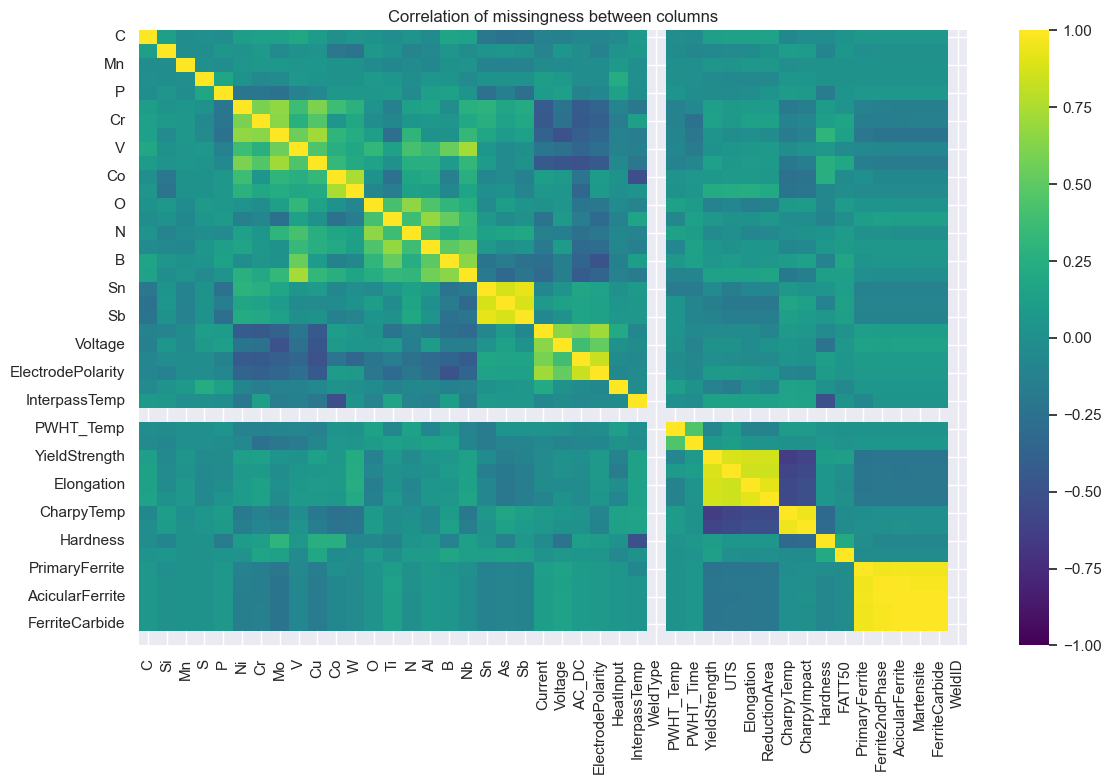

In [12]:
mvh.show_missing_summary(top=20)
mvh.plot_missingness('bar')
mvh.plot_missingness('heatmap')

## 3. Imputation strategy

The imputation strategy is : Thus we can try to intute patterns MAR, MCAR and MNAR:
- **MCAR**: correlations in the heatmap are close to 0 everywhere
- **MAR**: strong correlations between patterns of missing data
- **MNAR**: difficult to prove directly

Thus:
- **Chemical elements** (C, Mn, Cr, etc.) might be **MAR** : Correlated missing data between elements: depends on the analytical protocol
- **Mechanical properties** (YieldStrength, UTS, Elongation, etc.) might be **MAR** as well: Data missing together, therefore related to the availability of mechanical tests.
- **Microstructure** (PrimaryFerrite, AcicularFerrite, FerriteCarbide) might be **MNAR**: Probably absent when the microstructure is complex or not measured (non-random).
- **Process parameters** (Voltage, Polarity, InterpassTemp) might be **MCAR** or quasi-MCAR: Little or no correlation with other patterns of missing data.


With :

```python
process_param_columns = ['Current', 'Voltage','AC_DC', 'ElectrodePolarity', 'HeatInput', 'InterpassTemp', 'WeldType', 'PWHT_Temp', 'PWHT_Time']
chem_cols = ['C', 'Si', 'Mn', 'S', 'P', 'Ni', 'Cr', 'Mo', 'V', 'Cu', 'Co', 'W', 'O','Ti', 'N', 'Al', 'B', 'Nb', 'Sn', 'As', 'Sb']
mech_cols = [
    'YieldStrength', 'UTS', 'Elongation', 'ReductionArea',
    'CharpyTemp', 'CharpyImpact', 'Hardness', 'FATT50'
]
micro_cols = [
    'PrimaryFerrite', 'Ferrite2ndPhase', 'AcicularFerrite',
    'Martensite', 'FerriteCarbide'
]

In [13]:
# 2. Handle process parameters (mostly MCAR/quasi-MCAR)
process_param_columns = [
    'Current', 'Voltage','AC_DC', 'ElectrodePolarity',
    'HeatInput', 'InterpassTemp', 'WeldType', 'PWHT_Temp', 'PWHT_Time'
]
mvh.simple_impute_for_process_params(process_param_columns=process_param_columns)

# 3. Clean chemical columns (likely MAR)
chem_cols = [
    'C', 'Si', 'Mn', 'S', 'P', 'Ni', 'Cr', 'Mo', 'V',
    'Cu', 'Co', 'W', 'O','Ti', 'N', 'Al', 'B', 'Nb', 'Sn', 'As', 'Sb'
]
mvh.clean_chemical_columns(chem_cols=chem_cols)
mvh.iterative_impute_columns(columns=chem_cols, max_iter=10)

# # 4. Handle mechanical properties (likely MAR)
# mech_cols = [
#     'YieldStrength', 'UTS', 'Elongation', 'ReductionArea',
#     'CharpyTemp', 'CharpyImpact', 'Hardness', 'FATT50'
# ]
# mvh.clean_and_impute_mechanical(mech_cols=mech_cols, create_flag=True, max_iter=10)

# # 5. Handle microstructure (likely MNAR)
# micro_cols = [
#     'PrimaryFerrite', 'Ferrite2ndPhase', 'AcicularFerrite',
#     'Martensite', 'FerriteCarbide'
# ]
# # Create MNAR indicators
# mvh.mark_mnar(columns=micro_cols)

# # 6. Optional: drop rows/columns exceeding missingness thresholds
# mvh.drop_by_threshold(col_thresh=0.5, row_thresh=0.5)


clean_chemical_columns: C coerced, added 0 NaNs
clean_chemical_columns: Si coerced, added 0 NaNs
clean_chemical_columns: Mn coerced, added 0 NaNs
clean_chemical_columns: S coerced, added 0 NaNs
clean_chemical_columns: P coerced, added 0 NaNs
clean_chemical_columns: Ni coerced, added 0 NaNs
clean_chemical_columns: Cr coerced, added 0 NaNs
clean_chemical_columns: Mo coerced, added 0 NaNs
clean_chemical_columns: V coerced, added 0 NaNs
clean_chemical_columns: Cu coerced, added 0 NaNs
clean_chemical_columns: Co coerced, added 0 NaNs
clean_chemical_columns: W coerced, added 0 NaNs
clean_chemical_columns: O coerced, added 0 NaNs
clean_chemical_columns: Ti coerced, added 0 NaNs
clean_chemical_columns: N coerced, added 0 NaNs
clean_chemical_columns: Al coerced, added 0 NaNs
clean_chemical_columns: B coerced, added 0 NaNs
clean_chemical_columns: Nb coerced, added 0 NaNs
clean_chemical_columns: Sn coerced, added 0 NaNs
clean_chemical_columns: As coerced, added 0 NaNs
clean_chemical_columns: Sb c

In [14]:
# Quick evaluation of imputation strategies
# We'll mask a fraction of observed values and measure imputation quality

# Choose a subset of columns to evaluate
eval_cols = chem_cols[:5] + process_param_columns[:3]

# Use 10% masking for testing
mask_fraction = 0.1

# Evaluate median imputation for numeric and mode for categorical
eval_results = mvh.evaluate_imputation(
    holdout_cols=eval_cols,
    mask_frac=mask_fraction,
    strategy='median'  # 'median' for numeric, mode internally for categorical
)

# Show results
print("Imputation evaluation results:")
print(eval_results)


Imputation evaluation results:
       col    metric         score
0        C       mse      0.000468
1       Si       mse      0.004623
2       Mn       mse      0.157406
3        S       mse      0.000027
4        P       mse      0.000028
5  Current       mse  45336.789062
6  Voltage       mse     28.410606
7    AC_DC  accuracy      0.975758


c:\Users\marie\OneDrive - edu.escpeurope.eu\CS\ApprAuto\Weld-quality-prediction\src\preprocessing\data_cleaning.py:556: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  temp_df[col].fillna(temp_df[col].median(), inplace=True)
c:\Users\marie\OneDrive - edu.escpeurope.eu\CS\ApprAuto\Weld-quality-prediction\src\preprocessing\data_cleaning.py:556: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method

**Quick snapshot of imputation performance**:

Chemical elements (C, Si, Mn, S, P): Very low MSE, so median imputation works well for these. Only Mn is a bit higher (~0.16), suggesting more variability or outliers.

Process parameters (Current, Voltage, AC_DC): Current has huge MSE (~59k) — maybe strong variability or missing patterns. Voltage is fine (~198), AC_DC (categorical) has high accuracy (0.976), so mode imputation works well.

**Takeaways**:

For chemicals, simple median works fine.

For process parameters, check if Current has extreme outliers — maybe use KNN or domain-specific imputation.

In [15]:
timestamp = datetime.now().strftime("%Y_%m_%d")
mvh.save_dataframe(f"../data/data_imputed_{timestamp}.csv", format='csv')